# Deep Learning NLP Recommender Challenge - EDA

Amanda Cheney  
Part 1 of 2  
March 1, 2021

#### Objective  
Construct a deep learning network using NLP techniques that is able to predict whether a user will click on an unseen news article. The model should take as input user-news items and output a binary variable (1/0).   

#### This Notebook  
Initial EDA and data assembly for NLP analysis in following notebook.

### Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Load Data

In [2]:
news = pd.read_csv("https://inspire-data-challenge.s3.amazonaws.com/news_text.csv", sep='\t')

In [3]:
users = pd.read_csv("https://inspire-data-challenge.s3.amazonaws.com/user_news_clicks.csv")

### EDA  
First let's take a look at the news titles and abstracts before turning to user-news interactions and eventually merging the two for our final dataset. 

In [4]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   news_id   51282 non-null  object
 1   title     51282 non-null  object
 2   abstract  48616 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Note that 2666 or 5% of the news items in this data set are missing abstracts.

In [5]:
news.head()

,news_id,title,abstract
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


Let's have a look at a couple of sample items.

In [6]:
print(news.iloc[3]['title'])
print(news.iloc[3]['abstract'])

I Was An NBA Wife. Here's How It Affected My Mental Health.
I felt like I was a fraud, and being an NBA wife didn't help that. In fact, it nearly destroyed me.


In [7]:
print(news.iloc[-1]['title'])
print(news.iloc[-1]['abstract'])

Best Sports Car Deals for October
nan


### Nulls
Rather than drop the 5% of articles that do not have abstracts (perhaps because they are image based content) I decide to keep them as it will still be possible to conduct NLP on the titles.

In [10]:
news['abstract'] = news['abstract'].fillna("")

In [11]:
news.isnull().value_counts()

news_id  title  abstract
False    False  False       51282
dtype: int64

Now let's have a peek at user-news interactions 

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10951083 entries, 0 to 10951082
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   item     object
 2   click    int64 
dtypes: int64(1), object(2)
memory usage: 250.7+ MB


In [13]:
print("Number unique users:", users.user_id.nunique())
print("Number unique news articles (matches news dataset):", users.item.nunique())

Number unique users: 50000
Number unique news articles (matches news dataset): 51282


In [14]:
users.head()

,user_id,item,click
0,U13740,N55189,1
1,U13740,N42782,1
2,U13740,N34694,1
3,U13740,N45794,1
4,U13740,N18445,1


In [15]:
users['click'].value_counts(normalize=True)

0    0.512013
1    0.487987
Name: click, dtype: float64

At first blush it looks like a fairly even split of user-news interactions that result in clicks versus not.  

However, with 10,951,083 user-news interactions and only 50,000 unique users and 51,282 unique articles, it's worth considering if a given user may interact with a given news article more than once. If we identify such cases, we can simply condense the sum of a given users's total interactions with a given news article into a binary of click/no click.

In [16]:
users_no_dup = users.groupby(['user_id', 'item'], as_index=False).sum('clicks')

In [17]:
users_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5894984 entries, 0 to 5894983
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   item     object
 2   click    int64 
dtypes: int64(1), object(2)
memory usage: 179.9+ MB


In [18]:
users_no_dup.describe()

,click
count,5.894984e+06
mean,9.065305e-01
std,2.986565e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,3.100000e+02


Here we see that there are only 5,894,984 unique user-news interactions - that means about half of the original dataset of user-news interactions were capturing users interacting with news articles that had already seen. But in our case, whether a user saw and article 3 times and clicked on it all 3 times or saw it 3 times and never clicked on it all we are intersted in is whether or not there was at least one click. 

Before binarizing, let's check to see that this worked as intended.

In [19]:
users_no_dup.sort_values(by='click', ascending=False).head()

,user_id,item,click
1556089,U32146,N42781,310
1556292,U32146,N8148,310
4191566,U70493,N47020,262
634342,U19040,N18870,224
1975432,U38326,N61864,198


Wow - user "U32146" clicked on news item "N42781" 310 times! 
To ensure that this isn't an error, let's verify by checking back in with the original users dataset. 

In [21]:
u32146 = users[users['user_id']=='U32146']
print("Number total user-news interactions for user U32146:", u32146.shape[0])
n42781 = u32146[u32146['item']=='N42781']
print("Number total times user U32146 clicked on article N42781:", n42781.shape[0])

Number total user-news interactions for user U32146: 10872
Number total times user U32146 clicked on article N42781: 310


So perhaps user U32146 isn't what one has in mind as an 'average user' but the numbers check out, onwards to binarizing our target variable! 

In [22]:
users_no_dup['target'] = users_no_dup['click'].apply(lambda x: 1 if x>0 else 0) 

In [23]:
users_no_dup['target'].value_counts(normalize=True)

0    0.805182
1    0.194818
Name: target, dtype: float64

In [24]:
# In absolute numbers
users_no_dup['target'].value_counts()

0    4746537
1    1148447
Name: target, dtype: int64

## Identifying class imbalance  

Now that we have re-framed users-news interactions, we see that there is actually a notable class imbalance in the data set. Only 19.48% of articles get clicked on. 

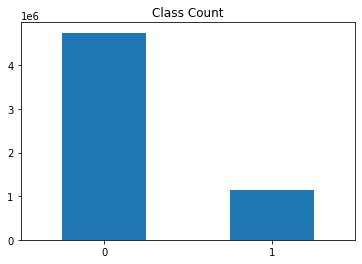

In [25]:
target_count = users_no_dup.target.value_counts()
target_count.plot(kind='bar', title='Class Count', rot=0);

## Implications of Class Imbalance for Model Evaluation
This class imbalance means that we should avoid relying on accuracy, since accuracy applies a "naive" 50% threshold to decide between classes, and that is not applicable here. In the "worst case scenario", our model could simply predict the majority class all the time (i.e. no click) and have fairly high accuracy, but such a model wouldn't offer much insight into what we are actually interested in, which is ultimately those articles that do get clicks.

In a business application, precision is likely to be the most important evaluation metric. This is because precision punishes false positives while not caring about the rate of false negatives. Here, a false positive would be inaccurately labelling an article that was not clicked as clicked, which in the context of a news recommender would mean showing a user an article they do not want to see and are not going to click on, which could have negative effects on user engagement and customer churn. That said, this same type of model applied to a different context, however, such as one which aims at educating users and ensuring that they have access to as many of the relevant news items as possible, might instead choose to prioritize recall performance rather than precision. 



Note that in the next notebook we will also need to conduct train/test split to ensure that the classes are proportionally represented.

In [26]:
df = users_no_dup.merge(news, how='left', left_on='item', right_on='news_id')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5894984 entries, 0 to 5894983
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   item      object
 2   click     int64 
 3   target    int64 
 4   news_id   object
 5   title     object
 6   abstract  object
dtypes: int64(2), object(5)
memory usage: 359.8+ MB


In [28]:
df.head()

,user_id,item,click,target,news_id,title,abstract
0,U100,N10121,0,0,N10121,Disney+ isn't working for some users on launch...,"Like most new online services, it looks like D..."
1,U100,N10532,0,0,N10532,Advocacy groups push Senate to include electio...,A group of advocacy organizations is pushing t...
2,U100,N11813,0,0,N11813,"Angels GM hinting at going after Gerrit Cole, ...",With payroll flexibility and the need to add a...
3,U100,N11856,0,0,N11856,Pro Russian hockey team tweets it wants fired ...,HC Dynamo Moscow of the KHL tweeted Tuesday th...
4,U100,N13827,0,0,N13827,DIY Closet Organization Ideas That Will Make G...,Getting dressed in the morning has never been ...


Let's get rid of duplicate columns and reorder.

In [29]:
df = df[['user_id', 'news_id', 'title', 'abstract', 'target']]

In [30]:
df.head()

,user_id,news_id,title,abstract,target
0,U100,N10121,Disney+ isn't working for some users on launch...,"Like most new online services, it looks like D...",0
1,U100,N10532,Advocacy groups push Senate to include electio...,A group of advocacy organizations is pushing t...,0
2,U100,N11813,"Angels GM hinting at going after Gerrit Cole, ...",With payroll flexibility and the need to add a...,0
3,U100,N11856,Pro Russian hockey team tweets it wants fired ...,HC Dynamo Moscow of the KHL tweeted Tuesday th...,0
4,U100,N13827,DIY Closet Organization Ideas That Will Make G...,Getting dressed in the morning has never been ...,0


In [31]:
df.tail()

,user_id,news_id,title,abstract,target
5894979,U9999,N5978,"Eric Tse, 24, just became a billionaire overnight",A 24-year-old business school graduate has jus...,1
5894980,U9999,N61022,"Roommate, her boyfriend charged in death of mi...",Missing Atlanta student Alexis Crawford was fo...,1
5894981,U9999,N62471,"Trent Williams fails physical, experiencing di...",Washington Redskins tackle Trent Williams' hea...,1
5894982,U9999,N64049,"After Soldiers Surrender El Chapo's Son, a Sho...",In the days following the siege of the city of...,1
5894983,U9999,N64503,'Time was of the essence': Politicians add to ...,"Kamille ""Cupcake"" McKinney was playing at a bi...",1


In [38]:
with open('full_df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)